In [1]:
# Core libraries
import os  # Operating system functionality
import sys  # System-specific parameters and functions
import re  # Regular expressions for pattern matching
import json  # JSON parsing and serialization
import csv  # CSV file reading and writing
import ast  # Abstract syntax trees (e.g., for safely evaluating strings)
import warnings  # Warning control
from collections import defaultdict, Counter  # Collection utilities for counting and default dictionaries

# Data manipulation and analysis
import pandas as pd  # Data analysis and manipulation
import numpy as np  # Numerical computing
from sklearn.preprocessing import StandardScaler  # Feature scaling
from sklearn.impute import KNNImputer, SimpleImputer  # Handling missing data
from sklearn.model_selection import train_test_split  # Splitting datasets
from sklearn.ensemble import GradientBoostingClassifier  # Gradient Boosting model
from sklearn.metrics import roc_auc_score, mean_squared_error  # Performance metrics
from sklearn.inspection import permutation_importance  # Feature importance
from sklearn.cluster import KMeans  # K-means clustering
from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF vectorizer for text data
import xgboost as xgb  # XGBoost library for gradient boosting
from itertools import combinations
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from scipy.stats import ks_2samp
from sklearn.ensemble import RandomForestClassifier
import itertools

# Geospatial analysis
import geopandas as gpd  # Geospatial data analysis
from geopy.distance import geodesic  # Geodesic distance computation
import contextily as ctx  # Contextual tile maps for geospatial data

# Natural Language Processing (NLP)
import nltk  # Natural language processing toolkit
from nltk.sentiment import SentimentIntensityAnalyzer  # Sentiment analysis
from nltk.tokenize import word_tokenize  # Tokenization of text
from textblob import TextBlob  # Text processing (sentiment analysis, translation, etc.)
from sentence_transformers import SentenceTransformer  # Sentence embedding models
from bs4 import BeautifulSoup  # Parsing HTML/XML content

# Visualization
import matplotlib.pyplot as plt  # Plotting library
from matplotlib.colors import LogNorm  # Logarithmic normalization for plots
import seaborn as sns  # Statistical data visualization

# Progress tracking
from tqdm import tqdm  # Progress bars for loops

# Suppress warnings
warnings.filterwarnings('ignore')  # Ignore warning messages

# NLTK resource downloads
nltk.download('vader_lexicon')  # Download sentiment analysis resources
nltk.download('punkt')  # Download tokenization resources

C:\Users\22451\.conda\envs\pytorch\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
C:\Users\22451\.conda\envs\pytorch\Lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may h

True

In [2]:

df_train = pd.read_csv('../../data/original data/train.csv')
df_test = pd.read_csv('../../data/original data/test.csv')

In [3]:
combined_feature = ['amenities', 'neighbourhood_cleansed']
df_train_simple = df_train.drop(columns=combined_feature)
df_test_simple = df_test.drop(columns=combined_feature)
df_train_amenity = df_train[combined_feature]
df_test_amenity = df_test[combined_feature]

In [4]:
def classify_features(df):
    # Initialize lists to store different feature types
    numeric_features = []
    categorical_features = []
    text_features = []
    
    for column in df.columns:
        try:
            dtype = df[column].dtype  # Get the data type of the column
            
            # Check if the feature is numeric
            if pd.api.types.is_numeric_dtype(dtype):
                unique_values = df[column].nunique()  # Count unique values
                # If the number of unique values is less than 10, classify as categorical
                if unique_values < 10:
                    categorical_features.append(column)
                else:
                    numeric_features.append(column)
            
            # Check if the feature is categorical or text-like
            elif pd.api.types.is_object_dtype(dtype) or pd.api.types.is_categorical_dtype(dtype):
                unique_values = df[column].nunique()  # Count unique values
                total_values = len(df[column])  # Count total values in the column
                
                # If the ratio of unique values to total values is below a threshold, treat it as categorical
                if unique_values / total_values < 0.1:
                    categorical_features.append(column)
                else:
                    text_features.append(column)  # Otherwise, treat it as text
            
            # Default case for non-numeric and non-object columns
            else:
                text_features.append(column)  # Assume text-like for other cases
        
        except Exception as e:
            # Print the column name and the error message
            print(f"Error while processing feature '{column}': {e}")
            # Optionally, you can log this information or raise the error after logging
    
    # Prepare formatted output
    output = (
        f"numeric_features = {numeric_features}\n"
        f"categorical_features = {categorical_features}\n"
        f"text_features = {text_features}"
    )
    print(output)
    
    # Return the classified features as a dictionary
    return {
        'numeric_features': numeric_features,
        'categorical_features': categorical_features,
        'text_features': text_features
    }

In [5]:
def onehot_encoded(df, column_name, prefix):
    # Get unique values from the train set for the specified column (excluding NaN)
    unique_values = df[column_name].dropna().unique()
    
    if len(unique_values) == 2:
        # If the column has only two unique values, create a single binary column
        value = unique_values[0]  # Take one value as the reference
        binary_column_name = f"{prefix}_{value}"
        df[binary_column_name] = (df[column_name] == value).astype(int)
    else:
        # For more than two unique values, create one-hot encoded columns
        for value in unique_values:
            onehot_column_name = f"{prefix}_{value}"
            df[onehot_column_name] = (df[column_name] == value).astype(int)
    
    # Drop the original column from the test set
    df.drop(columns=[column_name], inplace=True)

In [6]:
def process_date(df):
    print('Process date features...')
    # Turn the date column into a datetime object
    df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')
    df['first_review'] = pd.to_datetime(df['first_review'], errors='coerce')
    df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
    df['host_since_day'] = df['host_since'].apply(lambda x: (pd.Timestamp.now() - x).days) # Calculate the number of days since the host joined
    df.drop(columns=['host_since'], inplace=True)  # Drop the original host_since column
    df['review_duration'] = (df['last_review'] - df['first_review']).dt.days  # Calculate the duration between first and last review
    df.drop(columns=['first_review', 'last_review'], inplace=True)  # Drop the original date columns

In [7]:
def process_categorical(df, categorical_features):
    print('Process categorical features...')
    host_verifications(df)
    bathrooms_text(df)
    # One-hot encode the rest of the categorical features
    categorical_feature = [feature for feature in categorical_features if feature != 'neighbourhood_cleansed' and feature != 'host_verifications' and feature != 'bathrooms_text']
    # Iterate through the updated list and print unique values for each feature
    for feature in categorical_feature:
        onehot_encoded(df, feature, feature)
    
def host_verifications(df):
    print('Process host verifications')
    df['host_verifications'] = df['host_verifications'].apply(ast.literal_eval)
    # Get unique verification methods
    unique_verifications = set(item for sublist in df['host_verifications'] for item in sublist)
    
    # Generate one-hot encoding for each verification method
    for verification in unique_verifications:
        df[f'has_{verification}'] = df['host_verifications'].apply(lambda x: 1 if verification in x else 0)
    # Drop the original 'host_verifications' column as per the requirement
    df.drop(columns=['host_verifications'], inplace=True)
    
def bathrooms_text(df):
    # Define a function to parse the number of bathrooms and type (shared/private)
    def parse_bathrooms(text):
        if pd.isna(text):  # Handle NaN values
            return pd.Series([None, None, None])
        # Check if the bathroom is shared
        if 'shared' in text:
            shared = 1
        else:
            shared = 0
        # Check if the bathroom is private
        if 'private' in text or 'Private' in text:
            private = 1
        else:
            private = 0
        # Extract the number of bathrooms
        if 'Half' in text:  # Handle "Half-bath" or "Shared half-bath"
            number = 0.5
        else:
            number = ''.join(c for c in text if c.isdigit() or c == '.')  # Extract numeric value
            number = float(number) if number else 0  # Convert to float
        return pd.Series([number, shared, private])

    # Apply the parsing function to the 'bathrooms_text' column and create new columns
    df[['bathroom_count', 'shared', 'private']] = df['bathrooms_text'].apply(parse_bathrooms)
    df.drop(columns=['bathrooms_text'], inplace=True)  # Drop the original column


In [8]:
def process_text(df, train):
    print('Process text features...')
    sentiment_analysis(df, 'name')
    sentiment_analysis(df, 'description')
    add_review(df, train)
    
def sentiment_analysis(df, column):
    # Handle missing or non-string values by replacing them with empty strings
    df[column] = df[column].fillna("").astype(str)
    
    # Clean HTML tags and other unwanted characters
    def clean_text(text):
        text = re.sub(r'<.*?>', ' ', text)  # Remove HTML tags like <br />
        text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
        return text
    new_col = 'cleaned_' + column
    df[new_col] = df[column].apply(clean_text)
    # Tokenize the cleaned text
    df['tokens'] = df[new_col].apply(word_tokenize)

    # Initialize Sentiment Analyzer
    sia = SentimentIntensityAnalyzer()
    
    # Define keywords for promotional and action-oriented language
    promotional_keywords = [
        "luxury", "modern", "cozy", "spacious", "perfect", "comfortable",
        "unique", "renovated", "stylish", "bright", "elegant", "harmonious"
    ]
    action_keywords = ["limited", "only", "available now", "exclusive", "last chance"]
    
    # Initialize progress bar
    tqdm.pandas()
    
    # Feature 1: Text Length (Character Count)
    feature1 = column + '_text_length'
    df[feature1] = df[new_col].progress_apply(len)
    
    # Feature 2: Sentiment Score
    feature2 = column + '_sentiment_score'
    df[feature2] = df[new_col].progress_apply(lambda x: sia.polarity_scores(x)['compound'])
    
    # Feature 3: Unique Word Ratio
    def unique_word_ratio(tokens):
        unique_words = set(tokens)
        return len(unique_words) / len(tokens) if tokens else 0
    feature3 = column + '_unique_word_ratio'
    df[feature3] = df['tokens'].progress_apply(unique_word_ratio)
    
    # Feature 4: Promotional Keywords Frequency
    def keyword_frequency(tokens, keywords):
        token_count = Counter(tokens)
        return sum(token_count.get(keyword, 0) for keyword in keywords)
    feature4 = column + '_promotional_frequency'
    df[feature4] = df['tokens'].progress_apply(
        lambda x: keyword_frequency(x, promotional_keywords)
    )
    
    # Feature 5: Action-Oriented Keywords Frequency
    feature5 = column + '_action_frequency'
    df[feature5] = df['tokens'].progress_apply(
        lambda x: keyword_frequency(x, action_keywords)
    )
    
    # Show the resulting DataFrame
    print(df[[feature1, feature2, feature3, feature4, feature5]].head())
    df.drop(columns=[column, new_col, 'tokens'], inplace=True)
    
def add_review(df, train):
    # Load the review data
    if train == 1:
        review_df = pd.read_csv('../../data/important data/review_feature.csv')
    else:
        review_df = pd.read_csv('../../data/important data/review_feature_test.csv')
        
    for col in review_df.columns:
        df[col] = review_df[col]
        
    df.drop(columns=['reviews'], inplace=True)


In [9]:
def get_distance(df):
    # Coordinates of New York City center
    nyc_center = (40.7143528, -74.0059731)
    
    # Function to calculate distance between a point and NYC center
    def calculate_distance(row):
        # Create a tuple for the current row's coordinates
        point = (row['latitude'], row['longitude'])
        # Use geopy to calculate geodesic distance (in kilometers)
        return geodesic(point, nyc_center).kilometers
    
    # Apply the distance calculation function to each row and create a new column
    df['distance_to_nyc'] = df.apply(calculate_distance, axis=1)
    
    # Drop the original longitude and latitude columns
    df.drop(columns=['longitude', 'latitude'], inplace=True)    

In [10]:
def scale(df, numeric_features):
    # test whether ['id', 'longitude', 'latitude', 'price'] are in the numeric_features
    for feature in ['id', 'longitude', 'latitude', 'price']:
        if feature in numeric_features:
            numeric_features.remove(feature)
    # Step 1: Initialize the StandardScaler
    scaler = StandardScaler()
    # Step 2: Apply the scaler to the numeric features
    df[numeric_features] = scaler.fit_transform(df[numeric_features])

def fill_missing_with_knn(df, n_neighbors=3):
    def test_missing_value(df):
        missing_values = df.isnull().sum()
        print("Missing values per column:")
        print(missing_values[missing_values > 0])
    
    print('Before filling missing values:')
    test_missing_value(df)
    
    for col in df.columns:
        try:
            if df[col].dtype == 'bool':
                print(f"Column '{col}' is boolean, converting to int.")
                df[col] = df[col].astype(int)
            elif df[col].dtype == 'object':
                print(f"Column '{col}' is text, skipping KNN imputation.")
                continue
        except Exception as e:
            print(f"Error processing column '{col}': {e}")
    
    # Only process numeric columns
    try:
        numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
        if len(numeric_cols) == 0:
            print("No numeric columns found for KNN imputation.")
        else:
            imputer = KNNImputer(n_neighbors=n_neighbors)
            df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    except Exception as e:
        print(f"Error during KNN imputation: {e}")
    
    print('After filling missing values:')
    test_missing_value(df)
    
def test_missing_value(df):
    missing_values_summary = df.isnull().sum().to_frame(name='missing_count')
    missing_values_summary['missing_percentage'] = (df.isnull().sum() / len(df)) * 100
    missing_values_summary = missing_values_summary[missing_values_summary['missing_count'] > 0]
    print(missing_values_summary)

def binary_check(df, col):
    binary_check = {}

    for feature in col:
        unique_values = df[feature].dropna().unique()  
        binary_check[feature] = set(unique_values) == {True, False}
    
    for feature, is_binary in binary_check.items():
        if not is_binary:
            print(feature, df[feature].unique())

In [11]:
def amenity(df):
    # turn the string into a list of strings
    df['amenities'] = df['amenities'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    # Extract unique amenities from the list of lists
    unique_amenities = set(item for sublist in df['amenities'] for item in sublist if isinstance(item, str) and len(item) > 1)
    amenities_list = list(unique_amenities)
    print(amenities_list)
    
    cleaned_amenities_list = []
    for amenity in amenities_list:
        if isinstance(amenity, str):
            # Remove any problematic Unicode characters
            amenity = amenity.encode("utf-8", "ignore").decode("utf-8", "ignore")
            cleaned_str = amenity.strip()
            if cleaned_str:
                cleaned_amenities_list.append(cleaned_str)
            else:
                print(f"Warning: Empty string found and removed: '{amenity}'")
        else:
            print(f"Warning: Non-string value found and removed: {amenity}")
    
    # Step 2: Initialize the model and encode each amenity with error handling
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    embeddings = []
    for i, amenity in enumerate(cleaned_amenities_list):
        try:
            # Encoding the current amenity
            embedding = model.encode([amenity])  # Encode as a list with a single item
            embeddings.append(embedding[0])  # Append the resulting embedding
        except Exception as e:
            print(f"Error encoding amenity at index {i}: {amenity}")
            print(f"Exception: {e}")
            # Optionally, break the loop if you only want to identify the first issue
            break
            
    num_clusters = 14  # Adjust this based on the quality of cluster center it generated
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(embeddings)
    
    # Step 6: Assign each amenity to a cluster and create a mapping
    clustered_amenities = defaultdict(list)
    for i, label in enumerate(kmeans.labels_):
        clustered_amenities[f"Cluster_{label}"].append(cleaned_amenities_list[i])
    
    # Step 7: Generate a representative title for each cluster based on most common words
    def generate_cluster_title(amenities):
        # Extract common keywords from amenities in the cluster
        words = []
        for amenity in amenities:
            # Remove punctuation and split by spaces
            words.extend(re.findall(r'\b\w+\b', amenity))
        most_common_words = [word for word, _ in Counter(words).most_common(3)]
        # Join the top words as a cluster title
        return " ".join(most_common_words)
    
    cluster_titles = {cluster: generate_cluster_title(amenities) for cluster, amenities in clustered_amenities.items()}
    
    # Step 8: Display each cluster with its title and grouped amenities
    print("Amenity Clusters:")
    # Sort the clusters by their numerical order
    for cluster in sorted(clustered_amenities.keys(), key=lambda x: int(x.split('_')[1])):
        cluster_title = cluster_titles[cluster]
        amenities_str = ", ".join(clustered_amenities[cluster])
        print(f"\n{cluster} ({cluster_title}): {amenities_str}")
        
    for i in range(14):
        column_name = f"amenities_cluster_{i}"
        if f"Cluster_{i}" in clustered_amenities:
            # Step 10: For each property, check if any of its amenities belong to the current cluster
            df[column_name] = df['amenities'].apply(
                lambda amenities: any(amenity in amenities for amenity in clustered_amenities[f"Cluster_{i}"])
            )
        else:
            # If a cluster is missing (unlikely in this case), set all values to False
            df[column_name] = False
    
    # Step 11: Drop the original 'amenities' column as it's no longer needed
    df.drop(columns=['amenities'], inplace=True)
    
def neighborhood_cleansed(df):
    print('Process neighbourhood')
    neighbourhood_cleansed_counts = df['neighbourhood_cleansed'].value_counts()
    # Calculate the distribution of listings in each neighbourhood
    neighbourhood_cleansed_percentage = neighbourhood_cleansed_counts / len(df) * 100
    # Display the distribution of listings in each neighbourhood
    print("\nNeighbourhood Cleansed Distribution:")
    pd.set_option('display.max_rows', None)
    print(neighbourhood_cleansed_percentage)
    pd.set_option('display.max_rows', 10)
    
    # Filter neighbourhoods with at least 0.01% of the data
    significant_neighbourhoods = neighbourhood_cleansed_percentage[neighbourhood_cleansed_percentage >= 1].index
    print(significant_neighbourhoods)
    # Perform one-hot encoding on the filtered neighbourhoods
    df_onehot = pd.get_dummies(df['neighbourhood_cleansed'].where(df['neighbourhood_cleansed'].isin(significant_neighbourhoods), other=None))
    for col in df_onehot.columns:
        df[col] = df_onehot[col]  
    print(df.columns)
    df.drop(columns=['neighbourhood_cleansed'], inplace=True)  # Drop the original column
    print(df.columns)

In [12]:
def process(df, cols, train):
    process_date(df)
    process_categorical(df, cols)
    process_text(df, train)
    get_distance(df)

In [13]:
classify_features(df_train_simple)

numeric_features = ['latitude', 'longitude', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']
categorical_features = ['property_type', 'price', 'neighbourhood_group_cleansed', 'host_response_time', 'host_is_superhost', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'calculated_host_listings_count_shared_rooms', 'room_type', 'bathrooms_text', 'has_availabil

{'numeric_features': ['latitude',
  'longitude',
  'host_response_rate',
  'host_acceptance_rate',
  'host_listings_count',
  'host_total_listings_count',
  'calculated_host_listings_count',
  'calculated_host_listings_count_entire_homes',
  'calculated_host_listings_count_private_rooms',
  'accommodates',
  'bathrooms',
  'bedrooms',
  'beds',
  'availability_30',
  'availability_60',
  'availability_90',
  'availability_365',
  'minimum_nights',
  'maximum_nights',
  'number_of_reviews',
  'number_of_reviews_ltm',
  'number_of_reviews_l30d',
  'review_scores_rating',
  'review_scores_accuracy',
  'review_scores_cleanliness',
  'review_scores_checkin',
  'review_scores_communication',
  'review_scores_location',
  'review_scores_value',
  'reviews_per_month'],
 'categorical_features': ['property_type',
  'price',
  'neighbourhood_group_cleansed',
  'host_response_time',
  'host_is_superhost',
  'host_verifications',
  'host_has_profile_pic',
  'host_identity_verified',
  'calculated_h

In [14]:
label = ['price']
numeric_features = ['latitude', 'longitude', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']
categorical_features = ['property_type', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'host_response_time', 'host_is_superhost', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'calculated_host_listings_count_shared_rooms', 'room_type', 'bathrooms_text', 'has_availability', 'instant_bookable']
text_features = ['name', 'description', 'reviews']
date_features = ['host_since', 'first_review', 'last_review']

In [15]:
process(df_train_simple, categorical_features, 1)

In [16]:
classify_features(df_train_simple)

numeric_features = ['host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 'host_since_day', 'review_duration', 'bathroom_count', 'name_text_length', 'name_sentiment_score', 'name_unique_word_ratio', 'description_text_length', 'description_sentiment_score', 'description_unique_word_ratio', 'property_id', 'total_reviews', 'average_sentiment_score', 'max_sentiment_score', 'min_sentiment_s

{'numeric_features': ['host_response_rate',
  'host_acceptance_rate',
  'host_listings_count',
  'host_total_listings_count',
  'calculated_host_listings_count',
  'calculated_host_listings_count_entire_homes',
  'calculated_host_listings_count_private_rooms',
  'accommodates',
  'bathrooms',
  'bedrooms',
  'beds',
  'availability_30',
  'availability_60',
  'availability_90',
  'availability_365',
  'minimum_nights',
  'maximum_nights',
  'number_of_reviews',
  'number_of_reviews_ltm',
  'number_of_reviews_l30d',
  'review_scores_rating',
  'review_scores_accuracy',
  'review_scores_cleanliness',
  'review_scores_checkin',
  'review_scores_communication',
  'review_scores_location',
  'review_scores_value',
  'reviews_per_month',
  'host_since_day',
  'review_duration',
  'bathroom_count',
  'name_text_length',
  'name_sentiment_score',
  'name_unique_word_ratio',
  'description_text_length',
  'description_sentiment_score',
  'description_unique_word_ratio',
  'property_id',
  'tota

In [17]:
numeric_features_new = ['host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 'host_since_day', 'review_duration', 'bathroom_count', 'name_text_length', 'name_sentiment_score', 'name_unique_word_ratio', 'description_text_length', 'description_sentiment_score', 'description_unique_word_ratio', 'property_id', 'total_reviews', 'average_sentiment_score', 'max_sentiment_score', 'min_sentiment_score', 'sentiment_score_stddev', 'positive_ratio', 'neutral_ratio', 'negative_ratio', 'average_review_length', 'recommend_count', 'distance_to_nyc']
categorical_features_new = ['has_phone', 'has_email', 'has_work_email', 'shared', 'private', 'property_type_Entire rental unit', 'property_type_Private room in rental unit', 'property_type_Room in hotel', 'property_type_Private room in home', 'property_type_Private room in condo', 'property_type_Shared room in rental unit', 'property_type_Private room in serviced apartment', 'property_type_Entire guest suite', 'property_type_Entire townhouse', 'property_type_Private room in loft', 'property_type_Entire serviced apartment', 'property_type_Private room in townhouse', 'property_type_Entire guesthouse', 'property_type_Entire vacation home', 'property_type_Entire home', 'property_type_Entire place', 'property_type_Entire condo', 'property_type_Entire loft', 'property_type_Private room in guest suite', 'property_type_Private room in bungalow', 'property_type_Room in boutique hotel', 'property_type_Room in aparthotel', 'property_type_Private room in bed and breakfast', 'property_type_Entire bungalow', 'property_type_Private room in casa particular', 'property_type_Shared room in guest suite', 'property_type_Private room in resort', 'property_type_Entire villa', 'property_type_Private room in kezhan', 'property_type_Private room', 'property_type_Shared room in home', 'property_type_Entire cottage', 'property_type_Private room in guesthouse', 'property_type_Camper/RV', 'property_type_Boat', 'property_type_Private room in hostel', 'property_type_Shared room in hostel', 'property_type_Houseboat', 'property_type_Shared room in serviced apartment', 'property_type_Shared room in vacation home', 'property_type_Private room in ranch', 'property_type_Private room in camper/rv', 'property_type_Room in serviced apartment', 'property_type_Private room in vacation home', 'property_type_Private room in religious building', 'property_type_Shared room in townhouse', 'property_type_Private room in cottage', 'property_type_Shared room', 'property_type_Private room in tiny home', 'property_type_Private room in villa', 'property_type_Private room in houseboat', 'property_type_Shared room in guesthouse', 'property_type_Shared room in condo', 'property_type_Private room in tower', 'property_type_Shared room in casa particular', 'property_type_Tiny home', 'property_type_Private room in earthen home', 'property_type_Private room in castle', 'property_type_Casa particular', 'neighbourhood_group_cleansed_Brooklyn', 'neighbourhood_group_cleansed_Manhattan', 'neighbourhood_group_cleansed_Queens', 'neighbourhood_group_cleansed_Bronx', 'neighbourhood_group_cleansed_Staten Island', 'host_response_time_within a day', 'host_response_time_within an hour', 'host_response_time_within a few hours', 'host_response_time_a few days or more', 'host_is_superhost_True', 'host_has_profile_pic_True', 'host_identity_verified_True', 'calculated_host_listings_count_shared_rooms_0', 'calculated_host_listings_count_shared_rooms_1', 'calculated_host_listings_count_shared_rooms_5', 'calculated_host_listings_count_shared_rooms_4', 'calculated_host_listings_count_shared_rooms_6', 'calculated_host_listings_count_shared_rooms_3', 'calculated_host_listings_count_shared_rooms_2', 'calculated_host_listings_count_shared_rooms_12', 'room_type_Entire home/apt', 'room_type_Private room', 'room_type_Hotel room', 'room_type_Shared room', 'has_availability_True', 'instant_bookable_False', 'name_promotional_frequency', 'name_action_frequency', 'description_promotional_frequency', 'description_action_frequency']

In [18]:
binary_check(df_train_simple, categorical_features_new)

name_promotional_frequency [0 1 2]
description_promotional_frequency [2 0 1 3 4 6 5 8 7]
description_action_frequency [0 1 2 3 4]


In [19]:
# remove ['name_promotional_frequency', 'description_promotional_frequency', 'description_action_frequency'] from categorical_features_new and add them to numeric_features_new
numeric_features_new.extend(['name_promotional_frequency', 'description_promotional_frequency', 'description_action_frequency'])
categorical_features_new = [feature for feature in categorical_features_new if feature not in ['name_promotional_frequency', 'description_promotional_frequency', 'description_action_frequency']]

In [20]:
scale(df_train_simple, numeric_features_new)

In [21]:
fill_missing_with_knn(df_train_simple)

Before filling missing values:
Missing values per column:
host_response_rate             2203
host_acceptance_rate           2053
bathrooms                         3
bedrooms                         34
beds                             84
review_scores_rating           4474
review_scores_accuracy         4474
review_scores_cleanliness      4474
review_scores_checkin          4474
review_scores_communication    4474
review_scores_location         4475
review_scores_value            4474
reviews_per_month              4474
review_duration                4474
bathroom_count                   10
shared                           10
private                          10
total_reviews                  4521
average_sentiment_score        4521
max_sentiment_score            4521
min_sentiment_score            4521
sentiment_score_stddev         5802
positive_ratio                 4521
neutral_ratio                  4521
negative_ratio                 4521
average_review_length          4521
recomm

In [22]:
classify_features(df_test_simple)

numeric_features = ['id', 'latitude', 'longitude', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'accommodates', 'bathrooms', 'beds', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']
categorical_features = ['property_type', 'neighbourhood_group_cleansed', 'host_response_time', 'host_is_superhost', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'calculated_host_listings_count_shared_rooms', 'room_type', 'bathrooms_text', 'bedrooms', 'has_availability

{'numeric_features': ['id',
  'latitude',
  'longitude',
  'host_response_rate',
  'host_acceptance_rate',
  'host_listings_count',
  'host_total_listings_count',
  'calculated_host_listings_count',
  'calculated_host_listings_count_entire_homes',
  'calculated_host_listings_count_private_rooms',
  'accommodates',
  'bathrooms',
  'beds',
  'availability_30',
  'availability_60',
  'availability_90',
  'availability_365',
  'minimum_nights',
  'maximum_nights',
  'number_of_reviews',
  'number_of_reviews_ltm',
  'number_of_reviews_l30d',
  'review_scores_rating',
  'review_scores_accuracy',
  'review_scores_cleanliness',
  'review_scores_checkin',
  'review_scores_communication',
  'review_scores_location',
  'review_scores_value',
  'reviews_per_month'],
 'categorical_features': ['property_type',
  'neighbourhood_group_cleansed',
  'host_response_time',
  'host_is_superhost',
  'host_verifications',
  'host_has_profile_pic',
  'host_identity_verified',
  'calculated_host_listings_coun

In [23]:
id = ['id']
numeric_features = ['latitude', 'longitude', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']
categorical_features = ['property_type', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'host_response_time', 'host_is_superhost', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'calculated_host_listings_count_shared_rooms', 'room_type', 'bathrooms_text', 'has_availability', 'instant_bookable']
text_features = ['name', 'description', 'reviews']
date_features = ['host_since', 'first_review', 'last_review']

In [24]:
process(df_test_simple, categorical_features, 0)

Process date features...
Process categorical features...
Process host verifications
Process text features...


100%|██████████| 6727/6727 [00:00<00:00, 291716.20it/s]


   name_text_length  name_sentiment_score  name_unique_word_ratio  \
0                44                0.5994                     1.0   
1                48                0.0000                     1.0   
2                39                0.7717                     1.0   
3                42                0.0000                     1.0   
4                31                0.0000                     1.0   

   name_promotional_frequency  name_action_frequency  
0                           0                      0  
1                           0                      0  
2                           0                      0  
3                           0                      0  
4                           0                      0  


100%|██████████| 6727/6727 [00:00<00:00, 139255.35it/s]


   description_text_length  description_sentiment_score  \
0                      482                       0.8555   
1                      445                       0.8555   
2                      442                       0.9360   
3                      380                       0.7717   
4                      222                       0.3182   

   description_unique_word_ratio  description_promotional_frequency  \
0                       0.781609                                  1   
1                       0.770115                                  0   
2                       0.797297                                  2   
3                       0.875000                                  0   
4                       0.950000                                  1   

   description_action_frequency  
0                             0  
1                             0  
2                             0  
3                             0  
4                             0  


In [25]:
classify_features(df_test_simple)

numeric_features = ['id', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'accommodates', 'bathrooms', 'beds', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 'host_since_day', 'review_duration', 'bathroom_count', 'name_text_length', 'name_sentiment_score', 'name_unique_word_ratio', 'description_text_length', 'description_sentiment_score', 'description_unique_word_ratio', 'property_id', 'total_reviews', 'average_sentiment_score', 'max_sentiment_score', 'min_sentiment_score',

{'numeric_features': ['id',
  'host_response_rate',
  'host_acceptance_rate',
  'host_listings_count',
  'host_total_listings_count',
  'calculated_host_listings_count',
  'calculated_host_listings_count_entire_homes',
  'calculated_host_listings_count_private_rooms',
  'accommodates',
  'bathrooms',
  'beds',
  'availability_30',
  'availability_60',
  'availability_90',
  'availability_365',
  'minimum_nights',
  'maximum_nights',
  'number_of_reviews',
  'number_of_reviews_ltm',
  'number_of_reviews_l30d',
  'review_scores_rating',
  'review_scores_accuracy',
  'review_scores_cleanliness',
  'review_scores_checkin',
  'review_scores_communication',
  'review_scores_location',
  'review_scores_value',
  'reviews_per_month',
  'host_since_day',
  'review_duration',
  'bathroom_count',
  'name_text_length',
  'name_sentiment_score',
  'name_unique_word_ratio',
  'description_text_length',
  'description_sentiment_score',
  'description_unique_word_ratio',
  'property_id',
  'total_revi

In [26]:
id = ['id']
numeric_features_new2 = ['host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'accommodates', 'bathrooms', 'beds', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 'host_since_day', 'review_duration', 'bathroom_count', 'name_text_length', 'name_sentiment_score', 'name_unique_word_ratio', 'description_text_length', 'description_sentiment_score', 'description_unique_word_ratio', 'property_id', 'total_reviews', 'average_sentiment_score', 'max_sentiment_score', 'min_sentiment_score', 'sentiment_score_stddev', 'positive_ratio', 'neutral_ratio', 'negative_ratio', 'average_review_length', 'recommend_count', 'distance_to_nyc']
categorical_features_new2 = ['bedrooms', 'has_phone', 'has_email', 'has_work_email', 'shared', 'private', 'property_type_Entire home', 'property_type_Private room in rental unit', 'property_type_Entire loft', 'property_type_Entire rental unit', 'property_type_Room in hotel', 'property_type_Private room in home', 'property_type_Entire condo', 'property_type_Private room in townhouse', 'property_type_Camper/RV', 'property_type_Private room in guest suite', 'property_type_Room in boutique hotel', 'property_type_Entire townhouse', 'property_type_Shared room in condo', 'property_type_Entire guest suite', 'property_type_Shared room in rental unit', 'property_type_Entire vacation home', 'property_type_Entire serviced apartment', 'property_type_Private room in condo', 'property_type_Private room in serviced apartment', 'property_type_Private room in resort', 'property_type_Entire place', 'property_type_Room in serviced apartment', 'property_type_Tiny home', 'property_type_Private room in loft', 'property_type_Shared room in hostel', 'property_type_Shared room in home', 'property_type_Entire guesthouse', 'property_type_Entire bungalow', 'property_type_Private room in casa particular', 'property_type_Private room in guesthouse', 'property_type_Private room in bed and breakfast', 'property_type_Private room in vacation home', 'property_type_Private room in hostel', 'property_type_Private room', 'property_type_Room in aparthotel', 'property_type_Shared room in serviced apartment', 'property_type_Private room in villa', 'property_type_Houseboat', 'property_type_Shared room in casa particular', 'property_type_Private room in houseboat', 'property_type_Shared room in loft', 'property_type_Casa particular', 'property_type_Private room in earthen home', 'property_type_Private room in tiny home', 'property_type_Private room in bungalow', 'property_type_Boat', 'property_type_Shared room in townhouse', 'neighbourhood_group_cleansed_Queens', 'neighbourhood_group_cleansed_Brooklyn', 'neighbourhood_group_cleansed_Manhattan', 'neighbourhood_group_cleansed_Bronx', 'neighbourhood_group_cleansed_Staten Island', 'host_response_time_within an hour', 'host_response_time_within a day', 'host_response_time_within a few hours', 'host_response_time_a few days or more', 'host_is_superhost_False', 'host_has_profile_pic_True', 'host_identity_verified_True', 'calculated_host_listings_count_shared_rooms_0', 'calculated_host_listings_count_shared_rooms_3', 'calculated_host_listings_count_shared_rooms_2', 'calculated_host_listings_count_shared_rooms_4', 'calculated_host_listings_count_shared_rooms_6', 'calculated_host_listings_count_shared_rooms_1', 'calculated_host_listings_count_shared_rooms_12', 'calculated_host_listings_count_shared_rooms_5', 'room_type_Entire home/apt', 'room_type_Private room', 'room_type_Hotel room', 'room_type_Shared room', 'has_availability_True', 'instant_bookable_False', 'name_promotional_frequency', 'name_action_frequency', 'description_promotional_frequency', 'description_action_frequency']

In [27]:
# Compare numeric features
numeric_diff = list(set(numeric_features_new) ^ set(numeric_features_new2))
print("Numeric Features Differences:")
print(numeric_diff)
categorical_diff = list(set(categorical_features_new) ^ set(categorical_features_new2))
print("Categorical Features Differences:")
print(categorical_diff)

Numeric Features Differences:
['name_promotional_frequency', 'bedrooms', 'description_action_frequency', 'description_promotional_frequency']
Categorical Features Differences:
['property_type_Shared room', 'property_type_Entire cottage', 'bedrooms', 'property_type_Private room in ranch', 'property_type_Shared room in loft', 'property_type_Shared room in guesthouse', 'property_type_Private room in religious building', 'property_type_Shared room in guest suite', 'host_is_superhost_False', 'description_action_frequency', 'description_promotional_frequency', 'property_type_Private room in castle', 'property_type_Entire villa', 'name_promotional_frequency', 'property_type_Private room in kezhan', 'property_type_Private room in tower', 'property_type_Shared room in vacation home', 'property_type_Private room in camper/rv', 'host_is_superhost_True', 'property_type_Private room in cottage']


In [28]:
df_test_simple['host_is_superhost_True'] = [1 if x == 0 else 0 for x in df_test_simple['host_is_superhost_False']]
df_test_simple.drop(columns=['host_is_superhost_False'], inplace=True)
# remove 'host_is_superhost_False' from categorical_features_new2 and add 'host_is_superhost_True'
categorical_features_new2 = [feature for feature in categorical_features_new2 if feature != 'host_is_superhost_False']
categorical_features_new2.append('host_is_superhost_True')

In [29]:
binary_check(df_test_simple, categorical_features_new2)

bedrooms [ 3.  4.  1.  0.  2.  5.  6. nan  7.  8.]
name_promotional_frequency [0 1 2 3]
description_promotional_frequency [1 0 2 4 3 5 6 7 8]
description_action_frequency [0 2 1 3]


In [30]:
# remove ['name_promotional_frequency', 'description_promotional_frequency', 'description_action_frequency'] from categorical_features_new and add them to numeric_features_new
numeric_features_new2.extend(['name_promotional_frequency', 'description_promotional_frequency', 'description_action_frequency', 'bedrooms'])
categorical_features_new2 = [feature for feature in categorical_features_new2 if feature not in ['name_promotional_frequency', 'description_promotional_frequency', 'description_action_frequency', 'bedrooms']]

In [31]:
scale(df_test_simple, numeric_features_new2)

In [32]:
fill_missing_with_knn(df_test_simple)

Before filling missing values:
Missing values per column:
host_response_rate              951
host_acceptance_rate            897
bathrooms                         3
bedrooms                         14
beds                             56
review_scores_rating           2027
review_scores_accuracy         2027
review_scores_cleanliness      2027
review_scores_checkin          2027
review_scores_communication    2027
review_scores_location         2027
review_scores_value            2027
reviews_per_month              2027
review_duration                2027
bathroom_count                    7
shared                            7
private                           7
property_id                       2
total_reviews                  2055
average_sentiment_score        2055
max_sentiment_score            2055
min_sentiment_score            2055
sentiment_score_stddev         2583
positive_ratio                 2055
neutral_ratio                  2055
negative_ratio                 2055
averag

In [33]:
df_train_amenity['flag'] = 1
df_test_amenity['flag'] = 0
df_combined = pd.concat([df_train_amenity, df_test_amenity], axis=0).reset_index(drop=True)
amenity(df_combined)
neighborhood_cleansed(df_combined)
fill_missing_with_knn(df_combined)

['Verona gas stove', '75 inch HDTV with Amazon Prime Video, Hulu, HBO Max, premium cable, standard cable, Apple TV, Disney+, Netflix', '70 inch HDTV with Hulu, Amazon Prime Video, Netflix', 'Fisher & Paykel  stainless steel double oven', '43 inch HDTV with Amazon Prime Video, Hulu, Netflix, premium cable', '45 inch HDTV with Amazon Prime Video, Netflix', 'Fast wifi – 75 Mbps', '40 inch HDTV with Roku, Netflix', 'Bluetooth sound system', 'FRIGIDAIRE gas stove', 'Fast wifi – 306 Mbps', 'Fast wifi – 372 Mbps', 'Bloomberg refrigerator', '48 inch HDTV with standard cable', 'Mrs. Meyer’s  body soap', 'Hot Plate electric stove', '48 inch HDTV with Netflix', 'Fast wifi – 342 Mbps', 'Bosch induction stove', "L'Occitane conditioner", '44 inch HDTV with standard cable', 'Audioengine Bluetooth sound system', 'Gasland Chef GH60BF stainless steel gas stove', 'Le Labo shampoo', '75 inch HDTV with Netflix, HBO Max, Amazon Prime Video', 'TV with Amazon Prime Video, Roku, Netflix, Apple TV, standard cab

  File "C:\Users\22451\.conda\envs\pytorch\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Amenity Clusters:

Cluster_0 (premises on parking): Paid parking garage off premises, Free parking on premises, Shared backyard, Private outdoor kitchen, Paid street parking off premises, Free residential garage on premises – 10 spaces, Free residential garage on premises, Backyard - Fully fenced, Paid parking garage on premises, Exterior security cameras on property, Shared patio or balcony, Free carport on premises – 2 spaces, Free driveway parking on premises, Paid parking lot on premises, Courtyard view, Free parking garage on premises – 1 space, Paid parking lot on premises – 2 spaces, Lock on bedroom door, Backyard, Free residential garage on premises – 1 space, Smart lock, Window guards, Free carport on premises – 1 space, Paid parking lot on premises – 1 space, Paid parking garage on premises – 2 spaces, Private backyard, Shared backyard – Fully fenced, Paid parking garage on premises – 1 space, Free parking on premises – 4 spaces, Paid parking lot on premises – 4 spaces, Free 

In [34]:
df_amenity_train= df_combined[df_combined['flag'] == 1]
df_amenity_test = df_combined[df_combined['flag'] == 0]
df_train_processed = pd.concat([df_train_simple, df_amenity_train], axis=1)
df_test_processed = pd.concat([df_test_simple.reset_index(drop=True), df_amenity_test.reset_index(drop=True)], axis=1)

In [35]:
df_test_processed

,id,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,accommodates,bathrooms,...,Lower East Side,Midtown,Murray Hill,Prospect-Lefferts Gardens,Ridgewood,Theater District,Upper East Side,Upper West Side,Washington Heights,Williamsburg
0,3917.0,-1.081524,-1.524345,-0.299949,-0.324691,-0.381279,-0.267170,-0.244423,1.730510,0.663311,...,0,0,0,0,0,0,0,0,0,0
1,1885.0,0.335118,-1.989603,0.419042,0.750121,3.105534,-0.273045,5.422992,-0.935441,3.695333,...,0,0,0,0,0,0,0,0,0,0
2,1305.0,0.200910,0.074234,-0.299949,-0.333621,-0.381279,-0.267170,-0.244423,-0.402251,-0.347363,...,0,0,0,0,0,0,0,0,0,0
3,19328.0,-0.962228,-1.488556,-0.265287,-0.270301,-0.211309,-0.167283,-0.102541,-0.935441,3.695333,...,0,0,0,0,0,0,0,1,0,0
4,16511.0,0.379854,-0.128571,-0.299949,-0.333621,-0.381279,-0.267170,-0.244423,-0.402251,-0.347363,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6722,7205.0,0.379854,0.766156,-0.298959,-0.332809,-0.376422,-0.267170,-0.236541,-0.402251,-0.347363,...,0,0,0,0,0,0,0,0,0,0
6723,3954.0,-4.093753,-1.631712,-0.294007,-0.327938,-0.352141,-0.273045,-0.189247,-0.935441,-0.347363,...,0,0,0,0,0,0,0,0,0,0
6724,1358.0,0.335118,-1.989603,0.419042,0.750121,3.105534,-0.273045,5.422992,-0.935441,3.695333,...,0,0,0,0,0,0,0,0,0,0
6725,2793.0,0.379854,0.766156,-0.299949,-0.331997,-0.381279,-0.267170,-0.244423,-0.402251,-0.347363,...,0,0,0,0,0,0,0,1,0,0


In [36]:
def drop_inconsistent_columns(df_train, df_test, train_keep_cols=['price'], test_keep_cols=['id']):
    """
    Remove columns from df_train and df_test that are not shared between them,
    except for specified columns to keep in each dataframe.

    Args:
        df_train (pd.DataFrame): The training dataset.
        df_test (pd.DataFrame): The testing dataset.
        train_keep_cols (list): Columns to keep in df_train even if they are not in df_test.
        test_keep_cols (list): Columns to keep in df_test even if they are not in df_train.

    Returns:
        pd.DataFrame, pd.DataFrame: Updated df_train and df_test with consistent columns.
    """
    # Identify columns that are common between the two dataframes
    common_columns = df_train.columns.intersection(df_test.columns)
    
    # Add the keep columns to the respective dataframes
    train_columns_to_keep = list(common_columns) + train_keep_cols
    test_columns_to_keep = list(common_columns) + test_keep_cols
    
    # Keep only the relevant columns
    df_train = df_train[train_columns_to_keep]
    df_test = df_test[test_columns_to_keep]
    
    return df_train, df_test

# Example usage:
df_train_processed, df_test_processed = drop_inconsistent_columns(df_train_processed, df_test_processed)
df_train_processed.drop(columns=['flag'], inplace=True)
df_test_processed.drop(columns=['flag'], inplace=True)

In [37]:
df_train_processed.to_csv('../../data/important data/df_train_processed.csv', index=False)
df_test_processed.to_csv('../../data/important data/df_test_processed.csv', index=False)

In [50]:
def determine_interaction_terms(df, target, features, correlation_threshold=0.2, num_top_features=100, max_interaction_terms=1000):
    """
    Determine interaction terms to generate based on the training data.

    Parameters:
        df (pd.DataFrame): The training DataFrame containing features and the target variable.
        target (str): The name of the target column.
        features (list): A list of feature column names to consider for interaction terms.
        correlation_threshold (float): The threshold for feature pair correlation to include interaction terms.
        num_top_features (int): The number of top features to select based on feature importance.
        max_interaction_terms (int): The maximum number of interaction terms to generate.

    Returns:
        list: A list of tuples representing the feature pairs to be used for generating interaction terms.
    """
    # Separate features and target
    X = df[features]
    y = df[target]

    # Step 1: Calculate correlation matrix
    correlation_matrix = X.corr()

    # Step 2: Train a Random Forest model to get feature importance
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)

    # Step 3: Select top features based on importance
    top_features = feature_importances.nlargest(num_top_features).index.tolist()

    # Step 4: Determine interaction terms based on correlation and importance
    interaction_terms = []
    for feature1, feature2 in itertools.combinations(top_features, 2):
        correlation = abs(correlation_matrix.loc[feature1, feature2])
        # Allow lower correlation if max_interaction_terms is not reached
        if correlation > correlation_threshold or len(interaction_terms) < max_interaction_terms:
            interaction_terms.append((feature1, feature2))
        # Break early if max interaction terms reached
        if len(interaction_terms) >= max_interaction_terms:
            break

    return interaction_terms

def generate_interaction_terms(df, interaction_terms):
    """
    Generate interaction terms for the given DataFrame based on predefined feature pairs.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        interaction_terms (list): A list of tuples representing the feature pairs to be used for generating interaction terms.

    Returns:
        pd.DataFrame: A new DataFrame including the original features and the generated interaction terms.
    """
    result_df = df.copy()
    for feature1, feature2 in interaction_terms:
        interaction_term_name = f"{feature1}_x_{feature2}"
        result_df[interaction_term_name] = df[feature1] * df[feature2]

    return result_df

# Load preprocessed training and testing data
df_train_processed = pd.read_csv('../../data/important data/df_train_processed.csv')
df_test_processed = pd.read_csv('../../data/important data/df_test_processed.csv')

# Define columns for interaction term generation
target = 'price'
features_train = [col for col in df_train_processed.columns if col != target]
features_test = [col for col in df_test_processed.columns if col != 'id']

# Step 1: Determine interaction terms from training data
interaction_terms = determine_interaction_terms(
    df_train_processed, target=target, features=features_train, 
    correlation_threshold=0.2, num_top_features=50, max_interaction_terms=300
)

# Step 2: Generate interaction terms for training and testing data
train_cross = generate_interaction_terms(df_train_processed, interaction_terms)
test_cross = generate_interaction_terms(df_test_processed, interaction_terms)

# Step 3: Save the results to CSV
train_cross.to_csv('../../data/important data/train_cross.csv', index=False)
test_cross.to_csv('../../data/important data/test_cross.csv', index=False)


In [51]:

# def adversarial_validation(df_train, df_test, random_state=42):
#     """
#     Perform adversarial validation to compare the distribution of df_train and df_test.
#     """
#     # Step 1: Identify common columns
#     common_columns = df_train.columns.intersection(df_test.columns)
#     print(f"Common columns: {common_columns.tolist()}")
# 
#     # Filter columns and keep only common ones
#     df_train = df_train[common_columns]
#     df_test = df_test[common_columns]
# 
#     # Step 2: Check feature distributions (optional)
#     for col in common_columns:
#         print(f"Column: {col}")
#         print(f"Train distribution:\n{df_train[col].value_counts(normalize=True).head()}")
#         print(f"Test distribution:\n{df_test[col].value_counts(normalize=True).head()}")
# 
#     # Step 3: Create target column
#     df_train['target'] = 1
#     df_test['target'] = 0
# 
#     # Combine datasets
#     df_combined = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)
# 
#     # Save combined dataset for debugging
#     try:
#         df_combined.to_csv('../../data/temp data/df_combined.csv', index=False)
#     except Exception as e:
#         print(f"Could not save combined dataset: {e}")
# 
#     # Step 4: Separate features and target
#     X = df_combined.drop(columns=['target'])
#     y = df_combined['target']
# 
#     # Check for NaN values
#     nan_features = X.columns[X.isna().any()].tolist()
#     if nan_features:
#         print(f"Features containing NaN values: {nan_features}")
#         X = X.fillna(-1)  # Replace NaN values with -1 for consistency
#     else:
#         print("No features with NaN values detected.")
# 
#     # Step 5: Train-test split
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=random_state)
# 
#     # Step 6: Train classifier
#     model = GradientBoostingClassifier(random_state=random_state)
#     model.fit(X_train, y_train)
# 
#     # Step 7: Evaluate AUC
#     y_pred = model.predict_proba(X_val)[:, 1]
#     auc = roc_auc_score(y_val, y_pred)
# 
#     # Step 8: Feature importances
#     importances = model.feature_importances_
#     feature_importances = pd.DataFrame({
#         'Feature': X.columns,
#         'Importance': importances
#     }).sort_values(by='Importance', ascending=False).reset_index(drop=True)
# 
#     # Print results
#     print(f"AUC: {auc:.4f}")
#     print("Feature Importances (sorted):")
#     print(feature_importances)
# 
#     return auc, feature_importances

In [52]:
def adversarial_validation(train, test, threshold=0.05, random_state=42):
    """
    Perform adversarial validation to compare feature distributions between train and test datasets.

    Parameters:
    - train: DataFrame containing the training data.
    - test: DataFrame containing the test data.
    - threshold: Float, the p-value threshold for identifying significantly different feature distributions.
    - random_state: Int, random seed for reproducibility.

    Returns:
    - cleaned_train: DataFrame, training data with removed features.
    - cleaned_test: DataFrame, test data with removed features.
    """
    # Add a target column to distinguish train (label 0) and test (label 1)
    train['is_test'] = 0
    test['is_test'] = 1

    # Concatenate train and test datasets
    combined = pd.concat([train, test], axis=0, ignore_index=True)

    # Separate features and target
    X = combined.drop(columns=['is_test'])
    y = combined['is_test']

    # Split the combined dataset into training and validation sets for adversarial validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=random_state)

    # Train a random forest classifier
    clf = RandomForestClassifier(random_state=random_state)
    clf.fit(X_train, y_train)

    # Predict probabilities on the validation set and calculate AUC
    y_pred = clf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print(f"AUC: {auc:.4f}")

    # Calculate feature importance
    feature_importance = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
    print("Feature Importance:")
    print(feature_importance)

    # Identify features with significantly different distributions using the Kolmogorov-Smirnov test
    features_to_remove = []
    for feature in X.columns:
        stat, p_value = ks_2samp(train[feature], test[feature])
        if p_value < threshold:
            print(f"Feature '{feature}' has a significantly different distribution (p-value={p_value:.4e}).")
            features_to_remove.append(feature)

    # Remove identified features from both train and test sets
    cleaned_train = train.drop(columns=features_to_remove)
    cleaned_test = test.drop(columns=features_to_remove)

    return cleaned_train, cleaned_test

In [53]:
# def adversarial_validation(train, test, importance_threshold=0.01, random_state=42):
#     """
#     Perform adversarial validation to compare feature distributions between train and test datasets.
# 
#     Parameters:
#     - train: DataFrame containing the training data.
#     - test: DataFrame containing the test data.
#     - importance_threshold: Float, the minimum feature importance score for removal.
#     - random_state: Int, random seed for reproducibility.
# 
#     Returns:
#     - cleaned_train: DataFrame, training data with removed features.
#     - cleaned_test: DataFrame, test data with removed features.
#     """
#     # Add a target column to distinguish train (label 0) and test (label 1)
#     train['is_test'] = 0
#     test['is_test'] = 1
#     
#     # Concatenate train and test datasets
#     combined = pd.concat([train, test], axis=0, ignore_index=True)
#     
#     # Separate features and target
#     X = combined.drop(columns=['is_test'])
#     y = combined['is_test']
#     
#     # Split the combined dataset into training and validation sets for adversarial validation
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=random_state)
#     
#     # Train a random forest classifier
#     clf = RandomForestClassifier(random_state=random_state)
#     clf.fit(X_train, y_train)
#     
#     # Predict probabilities on the validation set and calculate AUC
#     y_pred = clf.predict_proba(X_val)[:, 1]
#     auc = roc_auc_score(y_val, y_pred)
#     print(f"AUC: {auc:.4f}")
#     
#     # Calculate feature importance
#     feature_importance = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
#     print("Feature Importance:")
#     print(feature_importance)
#     
#     # Identify features with importance above the threshold
#     features_to_remove = feature_importance[feature_importance > importance_threshold].index.tolist()
#     if features_to_remove:
#         print(f"Features with high importance (>{importance_threshold}):")
#         print(features_to_remove)
#     else:
#         print("No features with high importance detected.")
#     
#     # Remove identified features from both train and test sets
#     cleaned_train = train.drop(columns=features_to_remove)
#     cleaned_test = test.drop(columns=features_to_remove)
#     
#     return cleaned_train, cleaned_test


In [54]:
df_train_av = train_cross.copy()
df_test_av = test_cross.copy()
df_train_av.drop(columns=['price'], inplace=True)
df_test_av.drop(columns=['id'], inplace=True)
new_train, new_test = adversarial_validation(df_train_av, df_test_av)
df_train_droped = new_train.copy()
df_test_droped = new_test.copy()
df_train_droped['price'] = df_train_processed['price']
df_test_droped['id'] = df_test_processed['id']

AUC: 1.0000
Feature Importance:
description_action_frequency                     0.110415
name_unique_word_ratio                           0.082708
number_of_reviews_l30d                           0.061494
host_listings_count                              0.058204
minimum_nights                                   0.053007
                                                   ...   
calculated_host_listings_count_shared_rooms_1    0.000000
property_type_Entire condo                       0.000000
property_type_Entire place                       0.000000
calculated_host_listings_count_shared_rooms_5    0.000000
property_type_Entire guesthouse                  0.000000
Length: 471, dtype: float64
Feature 'host_response_rate' has a significantly different distribution (p-value=0.0000e+00).
Feature 'host_acceptance_rate' has a significantly different distribution (p-value=5.9831e-285).
Feature 'host_listings_count' has a significantly different distribution (p-value=0.0000e+00).
Feature 'host_to

In [63]:
df_train_droped.to_csv('../../data/important data/df_train_droped.csv', index=False)
df_test_droped.to_csv('../../data/important data/df_test_droped.csv', index=False)

In [55]:
new_train, new_test = adversarial_validation(new_train, new_test)

AUC: 0.6499
Feature Importance:
distance_to_nyc_x_maximum_nights                                         0.033901
host_listings_count_x_property_id                                        0.033588
distance_to_nyc_x_host_response_rate                                     0.032769
distance_to_nyc_x_host_since_day                                         0.032437
distance_to_nyc_x_name_text_length                                       0.032005
                                                                           ...   
room_type_Entire home/apt_x_property_type_Room in hotel                  0.000000
room_type_Entire home/apt_x_shared                                       0.000000
room_type_Entire home/apt_x_property_type_Room in boutique hotel         0.000000
room_type_Private room_x_room_type_Entire home/apt                       0.000000
room_type_Entire home/apt_x_property_type_Private room in rental unit    0.000000
Length: 167, dtype: float64


In [56]:
df_train_droped

,has_phone,has_email,has_work_email,shared,private,property_type_Entire rental unit,property_type_Private room in rental unit,property_type_Room in hotel,property_type_Private room in home,property_type_Private room in condo,...,room_type_Entire home/apt_x_property_id,room_type_Entire home/apt_x_property_type_Room in boutique hotel,accommodates_x_property_id,accommodates_x_property_type_Room in boutique hotel,host_listings_count_x_property_type_Room in hotel,host_listings_count_x_property_id,host_listings_count_x_property_type_Room in boutique hotel,calculated_host_listings_count_private_rooms_x_property_type_Room in hotel,is_test,price
0,1.0,1.0,0.0,0.0,0.0,1,0,0,0,0,...,-1.731940,0,-1.107409,0.0,-0.000000,0.503426,-0.0,-0.000000,0,4.0
1,1.0,1.0,0.0,0.0,1.0,0,1,0,0,0,...,-0.000000,0,0.722268,-0.0,-0.000000,0.505121,-0.0,-0.000000,0,3.0
2,1.0,1.0,0.0,0.0,0.0,1,0,0,0,0,...,-1.731499,0,0.722176,-0.0,-0.000000,0.415341,-0.0,-0.000000,0,3.0
3,1.0,1.0,0.0,0.0,0.0,0,1,0,0,0,...,-0.000000,0,1.636619,-0.0,0.000000,-0.771970,0.0,0.000000,0,0.0
4,1.0,1.0,0.0,0.0,0.0,0,0,1,0,0,...,-0.000000,0,0.721992,-0.0,0.425577,-0.736698,0.0,-0.235762,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15691,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,1.731058,0,1.106845,0.0,-0.000000,-0.480306,-0.0,-0.000000,0,5.0
15692,1.0,1.0,0.0,1.0,0.0,0,0,0,0,1,...,0.000000,0,-0.722084,-0.0,-0.000000,-0.503233,-0.0,-0.000000,0,0.0
15693,1.0,1.0,0.0,0.0,0.0,0,0,1,0,0,...,0.000000,0,0.192475,0.0,-0.264257,-0.457560,-0.0,-0.184699,0,5.0
15694,1.0,1.0,1.0,0.0,0.0,1,0,0,0,0,...,1.731720,0,-0.722268,-0.0,0.000000,7.399635,0.0,-0.000000,0,5.0


In [57]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, make_scorer
import matplotlib.pyplot as plt
from tqdm import tqdm

In [58]:
df  = df_train_droped.copy()

In [59]:
# Separate features and target
X = df.drop(columns=['price'])  # Replace 'target' with the actual target column name
y = df['price']

# Define RMSE as a scoring metric
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse = make_scorer(rmse_scorer, greater_is_better=False)  # Negative for minimization

# Set the minimum number of features to select
min_features_to_select = 1  # Minimum number of features to retain

# Initialize the XGBoost regressor
regressor = XGBRegressor(random_state=42)

# K-Fold for cross-validation
cv = KFold(n_splits=5)

# Custom Progress Bar for RFECV
class RFECVWithProgressBar(RFECV):
    def fit(self, X, y):
        # Wrap the cross-validation split loop in tqdm
        tqdm_cv = tqdm(cv.split(X, y), total=cv.get_n_splits(), desc="RFECV Progress")
        # Pass tqdm wrapped generator to super().fit
        self.cv = (split for split in tqdm_cv)
        return super().fit(X, y)

# Initialize RFECV with XGBoost as the estimator
rfecv = RFECVWithProgressBar(
    estimator=regressor,
    step=1,  # Number of features to remove at each iteration
    cv=cv,
    scoring=rmse,  # Use RMSE as the scoring metric
    min_features_to_select=min_features_to_select,
    n_jobs=2,  # Use multiple cores for computation
)

# Fit the RFECV object
rfecv.fit(X, y)

# Print the optimal number of features
print(f"Optimal number of features: {rfecv.n_features_}")

# Output the selected features
selected_features = X.columns[rfecv.support_]
print(f"Selected features: {list(selected_features)}")

RFECV Progress: 100%|██████████| 5/5 [00:00<00:00, 553.95it/s]


Optimal number of features: 34
Selected features: ['shared', 'private', 'property_type_Private room in rental unit', 'property_type_Room in hotel', 'neighbourhood_group_cleansed_Manhattan', 'host_response_time_within a day', 'host_response_time_within an hour', 'host_response_time_within a few hours', 'host_response_time_a few days or more', 'calculated_host_listings_count_shared_rooms_1', 'calculated_host_listings_count_shared_rooms_3', 'room_type_Private room', 'room_type_Shared room', 'instant_bookable_False', 'distance_to_nyc', 'amenities_cluster_1', 'amenities_cluster_5', 'amenities_cluster_9', 'amenities_cluster_10', 'amenities_cluster_13', 'Murray Hill', 'Upper West Side', 'room_type_Private room_x_neighbourhood_group_cleansed_Manhattan', 'minimum_nights_x_property_type_Room in boutique hotel', 'distance_to_nyc_x_room_type_Entire home/apt', 'distance_to_nyc_x_accommodates', 'distance_to_nyc_x_calculated_host_listings_count_entire_homes', 'distance_to_nyc_x_neighbourhood_group_cl

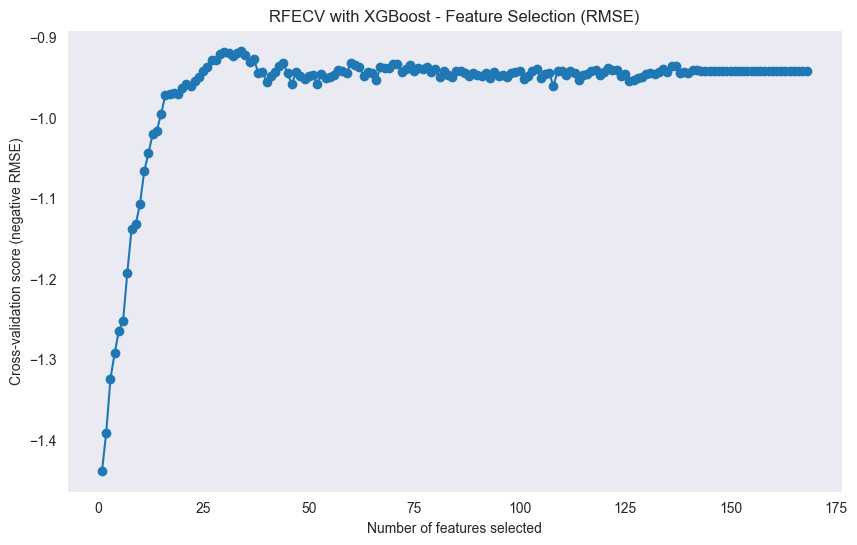

In [62]:
# Visualization: Plot number of features vs. cross-validation scores
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (negative RMSE)")
plt.title("RFECV with XGBoost - Feature Selection (RMSE)")
plt.plot(
    range(min_features_to_select, len(rfecv.cv_results_["mean_test_score"]) + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],  # Use mean test scores from cv_results_
    marker='o',
)
plt.grid()
plt.show()

In [61]:
selected_features = ['shared', 'private', 'property_type_Private room in rental unit', 'property_type_Room in hotel', 'neighbourhood_group_cleansed_Manhattan', 'host_response_time_within a day', 'host_response_time_within an hour', 'host_response_time_within a few hours', 'host_response_time_a few days or more', 'calculated_host_listings_count_shared_rooms_1', 'calculated_host_listings_count_shared_rooms_3', 'room_type_Private room', 'room_type_Shared room', 'instant_bookable_False', 'distance_to_nyc', 'amenities_cluster_1', 'amenities_cluster_5', 'amenities_cluster_9', 'amenities_cluster_10', 'amenities_cluster_13', 'Murray Hill', 'Upper West Side', 'room_type_Private room_x_neighbourhood_group_cleansed_Manhattan', 'minimum_nights_x_property_type_Room in boutique hotel', 'distance_to_nyc_x_room_type_Entire home/apt', 'distance_to_nyc_x_accommodates', 'distance_to_nyc_x_calculated_host_listings_count_entire_homes', 'distance_to_nyc_x_neighbourhood_group_cleansed_Manhattan', 'distance_to_nyc_x_availability_30', 'distance_to_nyc_x_calculated_host_listings_count', 'distance_to_nyc_x_property_type_Private room in rental unit', 'distance_to_nyc_x_beds', 'host_listings_count_x_property_type_Room in hotel', 'calculated_host_listings_count_private_rooms_x_property_type_Room in hotel']
df_train_fs = df_train_droped[selected_features]
df_test_fs = df_test_droped[selected_features]
adversarial_validation(df_train_fs, df_test_fs)

AUC: 0.7027
Feature Importance:
distance_to_nyc_x_accommodates                                   0.120904
distance_to_nyc_x_calculated_host_listings_count                 0.120812
distance_to_nyc_x_availability_30                                0.112917
distance_to_nyc_x_beds                                           0.112344
distance_to_nyc_x_calculated_host_listings_count_entire_homes    0.110965
                                                                   ...   
calculated_host_listings_count_shared_rooms_1                    0.001561
Murray Hill                                                      0.001181
room_type_Shared room                                            0.001037
property_type_Room in hotel                                      0.000963
calculated_host_listings_count_shared_rooms_3                    0.000811
Length: 34, dtype: float64


(       shared  private  property_type_Private room in rental unit  \
 0         0.0      0.0                                          0   
 1         0.0      1.0                                          1   
 2         0.0      0.0                                          0   
 3         0.0      0.0                                          1   
 4         0.0      0.0                                          0   
 ...       ...      ...                                        ...   
 15691     0.0      0.0                                          0   
 15692     1.0      0.0                                          0   
 15693     0.0      0.0                                          0   
 15694     0.0      0.0                                          0   
 15695     1.0      0.0                                          0   
 
        property_type_Room in hotel  neighbourhood_group_cleansed_Manhattan  \
 0                                0                                       0   
